# 載入常用程式庫

In [1]:
#請執行以下代碼，確保環境跟老師一致
!pip install --upgrade gdown==5.1.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [2]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/adventures/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/adventures/'

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=14)

from datetime import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
import sklearn
assert sklearn.__version__ >= "0.20"
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import sys
import gdown
import requests
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from pandas.plotting import register_matplotlib_converters

figure_dir = groot_dir + 'figure/clustering/'
data_dir = groot_dir + 'clustering/'

gfigure = lambda name: figure_dir + name + '.png'
output_fig = lambda name: plt.savefig( gfigure(name), dpi = 300)

local_time = lambda x, offset: x + relativedelta(hours= offset)
def local_now(hours = 8):
    return datetime.now() + relativedelta(hours = hours if in_colab else 0)

def print_now():
    return print(local_now())

def print_local_now():
    return print('Local Time:', local_now())

def DropboxLink(did, fname):
    return 'https://dl.dropboxusercontent.com/s/%s/%s' % \
    (did, fname)

def fetch_gdrive_file(fid, local_save):
    remote_url = 'https://drive.google.com/uc?id=' + fid
    gdown.download(remote_url, local_save, quiet = False)

def fetch_file_via_requests(url, save_in_dir):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    output_fpath = save_in_dir + local_filename
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(output_fpath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return output_fpath

def acct_string(num):
    s0 = str(num)
    if len(s0) <=3:
        return s0
    num_section = int(len(s0)/3)
    remaining_start = len(s0) % 3
    s = s0[:remaining_start]
    for i in range(num_section):
        s += ',%s' % s0[remaining_start + i*3 :remaining_start + (i+1)*3]
    return s

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)
print('Data storage points to ==>', data_dir)

print('\nThis module is amied to leran clustering basics...')
print('\nLibraries and dependenciess imported')
print_now()

Mounted at /content/drive

Running on linux
Python Version 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Data storage points to ==> /content/drive/My Drive/adventures/clustering/

This module is amied to leran clustering basics...

Libraries and dependenciess imported
2025-06-08 15:54:43.837941


In [3]:
def start_plot(figsize=(10, 8), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1,1)
    # plt.tight_layout()
    with sns.axes_style(style):
        ax = fig.add_subplot(gs[0,0])
    return ax

def grid_plot(figsize=(18, 14), style = 'whitegrid'):
    fig = plt.figure(figsize=figsize)
    # plt.tight_layout()
    gs=fig.add_gridspec(2, 2)
    with sns.axes_style(style):
        ax0 = fig.add_subplot(gs[0,0])
        ax1 = fig.add_subplot(gs[0,1])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
    return [ax0, ax1, ax2, ax3]

# Download File 下載資料到硬碟

In [ ]:
#連結已失效
# fetch_file_via_requests(
#     DropboxLink('teqrg5e5nyxpd59', 'Mall.csv'), data_dir )

# fetch_file_via_requests(
#     DropboxLink('2j1vjne1e8sdgr1', 'coffee5.csv'), data_dir )

# fetch_file_via_requests(
#     DropboxLink('qbaykxstu537u54', 'Clustering_gmm.csv'), data_dir )

# fetch_file_via_requests(
#     DropboxLink('l3o97cclfs7nw4j', 'coffee6.csv'), data_dir )


In [6]:
MALL='1U5tiuXLY3US95fKnHHI5PbF2YHGFq2Rb'
COFFEE6='1I3bGtJMh6SKge4ycPp4Pl75HzIMLiLek'
COFFEE7='1ytiA2C_5ZY2pddfRBUaD1ckwD8munjdD'
CLUSTERGMM='1hkMaTXrtHj9hYhuJCFC0PCILTWY0NzS1'

fetch_gdrive_file(MALL, os.path.join(data_dir, 'Mall.csv'))
fetch_gdrive_file(COFFEE6, os.path.join(data_dir, 'coffee6.csv'))
fetch_gdrive_file(COFFEE7, os.path.join(data_dir, 'coffee7.csv'))
fetch_gdrive_file(CLUSTERGMM, os.path.join(data_dir, 'Clustering_gmm.csv'))

Downloading...
From: https://drive.google.com/uc?id=1U5tiuXLY3US95fKnHHI5PbF2YHGFq2Rb
To: /content/drive/My Drive/adventures/clustering/Mall.csv
100%|██████████| 4.29k/4.29k [00:00<00:00, 7.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I3bGtJMh6SKge4ycPp4Pl75HzIMLiLek
To: /content/drive/My Drive/adventures/clustering/coffee6.csv
100%|██████████| 2.61k/2.61k [00:00<00:00, 1.46MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ytiA2C_5ZY2pddfRBUaD1ckwD8munjdD
To: /content/drive/My Drive/adventures/clustering/coffee7.csv
100%|██████████| 2.96k/2.96k [00:00<00:00, 5.47MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hkMaTXrtHj9hYhuJCFC0PCILTWY0NzS1
To: /content/drive/My Drive/adventures/clustering/Clustering_gmm.csv
100%|██████████| 18.4k/18.4k [00:00<00:00, 36.3MB/s]


In [7]:
mallfile = os.path.join(data_dir, 'Mall.csv')
mall = pd.read_csv(mallfile)
mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
mdf = pd.DataFrame(
    data = mall.iloc[:,[3, 4]].values,
    columns = ['X1', 'X2']
)
mdf.head()

,X1,X2
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


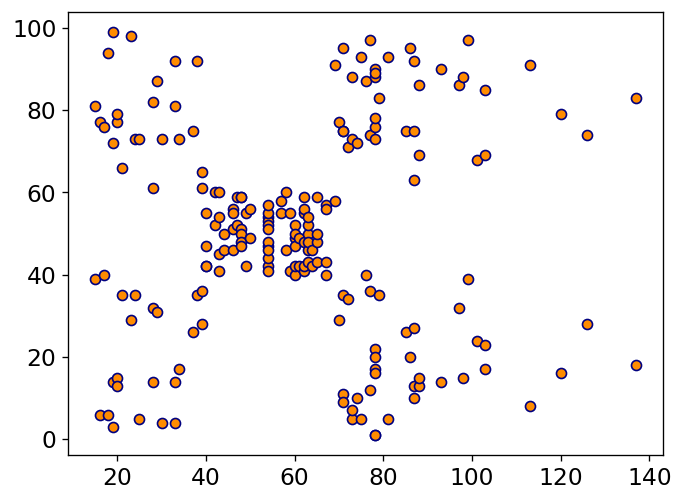

In [10]:
figure = plt.figure(dpi=120)
plt.scatter(mdf.X1, mdf.X2, color='darkorange', edgecolor='navy')

# Hierarchical Agglomerative Clustering

- [sklearn AllgomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

### 用 scipy 製作 dendogram




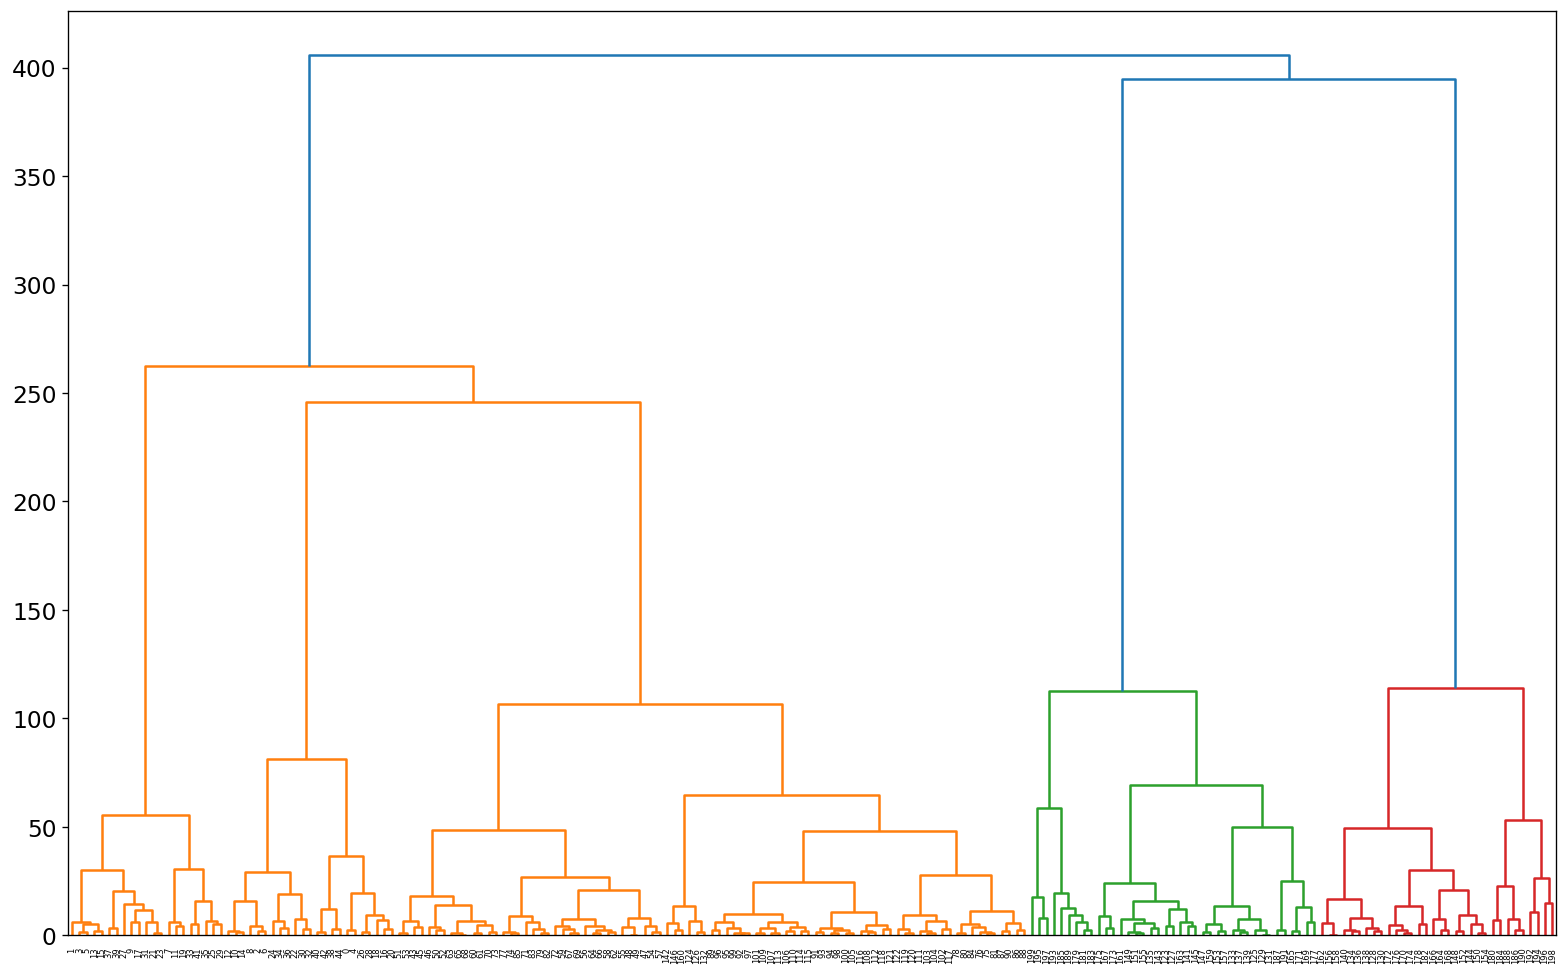

In [11]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import cut_tree, linkage

hc = sch.linkage(mdf.values, method='ward')
_, ax = plt.subplots(dpi=120, figsize=(16, 10))
dendrogram = sch.dendrogram(hc, ax=ax)

### scikit-learn 的做法

In [12]:
from sklearn.cluster import AgglomerativeClustering

n_k = 5

model = AgglomerativeClustering(n_clusters=n_k, linkage='ward')

model.fit(mdf.values)

labels = model.labels_


In [13]:
labels

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 1,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 2,
       1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2])

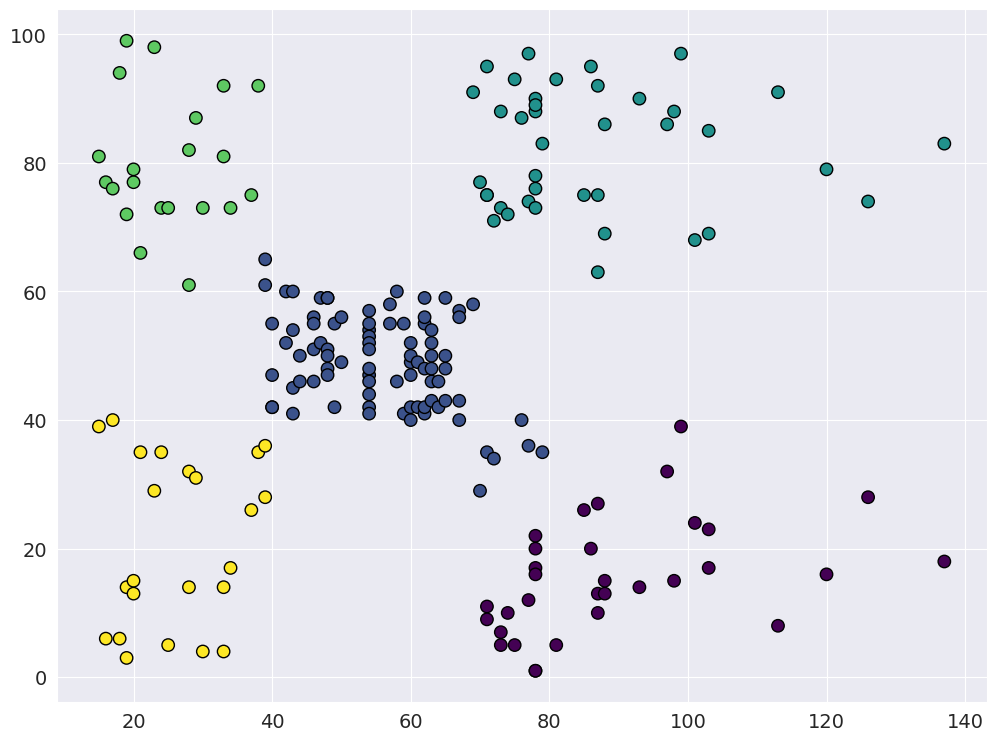

In [14]:
ax = start_plot(figsize=(12, 9), style = 'darkgrid')
ax.scatter(mdf.X1, mdf.X2, c = labels, cmap = 'viridis',
           edgecolor = 'k', s = 80)

### Comparison of Linkages （距離計算方式的比較）

In [15]:
%%time
linkages=['ward', 'complete', 'average', 'single']

hlabels = np.zeros((4, len(mdf)), dtype=np.int_)

for  i in range(len(linkages)):
    model =  AgglomerativeClustering(n_clusters=5,
        linkage = linkages[i])
    model.fit(mdf.values)
    hlabels[i] = model.labels_


CPU times: user 9.26 ms, sys: 0 ns, total: 9.26 ms
Wall time: 10.4 ms


In [16]:
hlabels.shape

(4, 200)

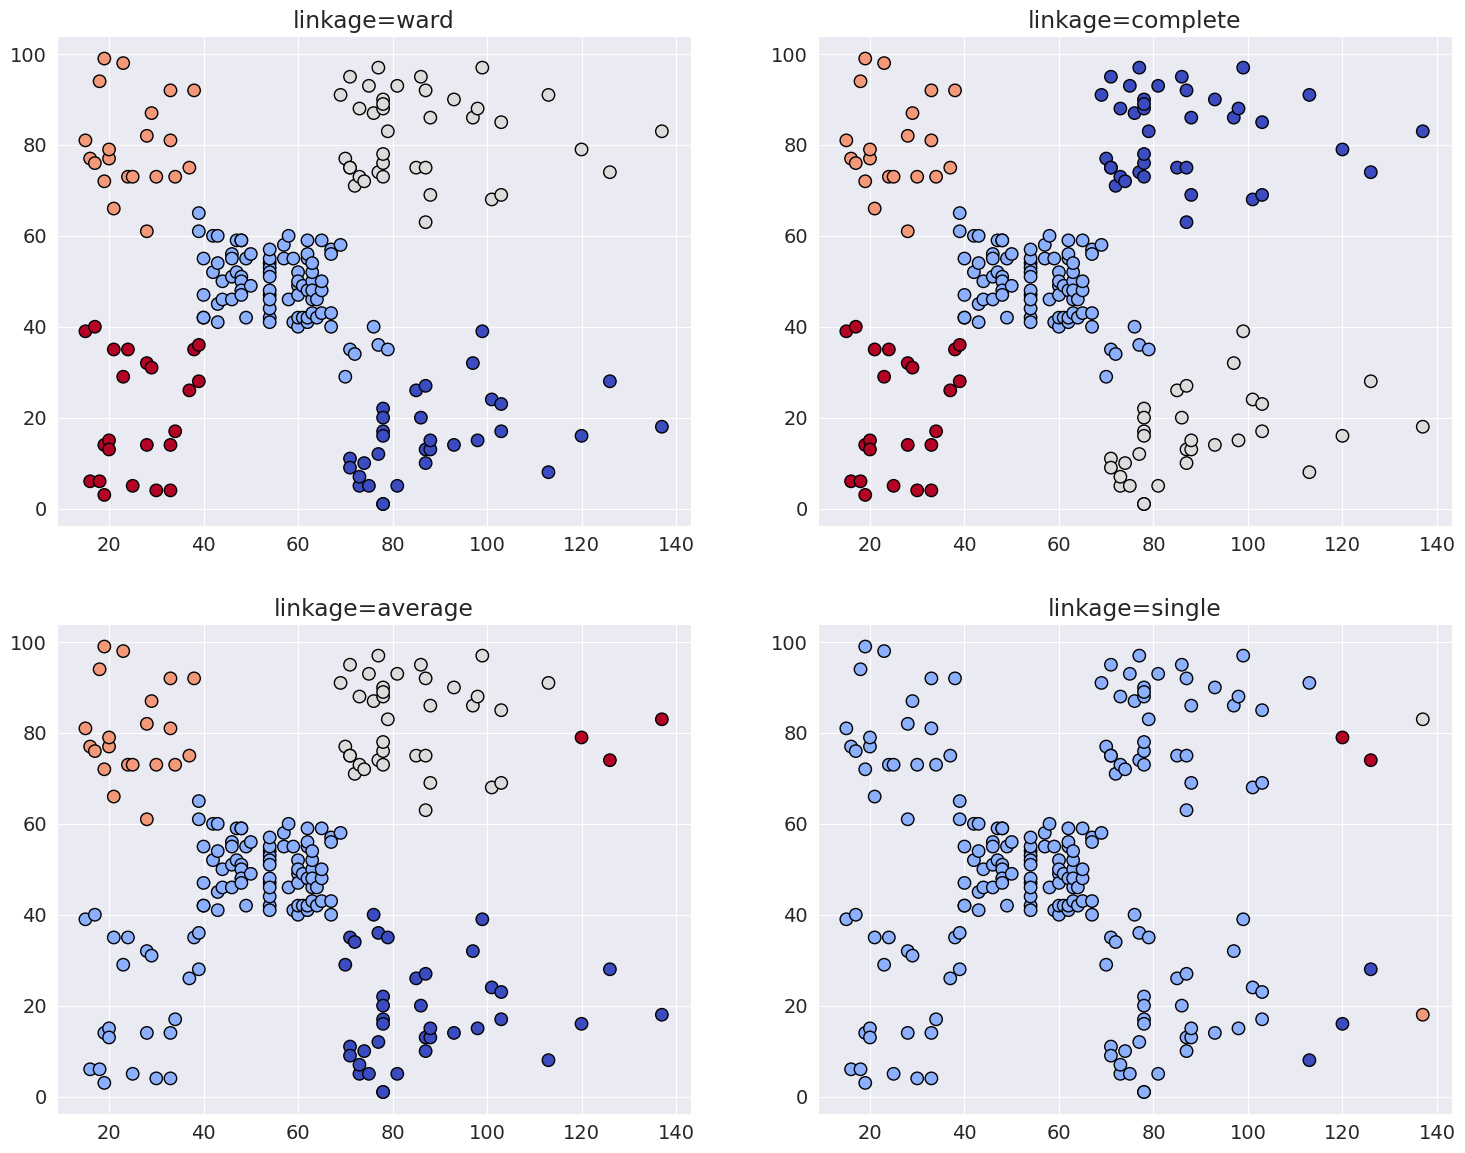

In [17]:
ax = grid_plot(figsize=(18, 14), style = 'darkgrid')

for i in range(len(linkages)):
    ax[i].scatter(mdf.X1, mdf.X2, c = hlabels[i], cmap = 'coolwarm',
        edgecolor='k', s = 80)
    ax[i].set_title('linkage=%s' % linkages[i])


# 咖啡漫步地圖

 - 發想源起 [Using Unsupervised Learning to plan a vacation to Paris: Geo-location clustering](https://towardsdatascience.com/using-unsupervised-learning-to-plan-a-paris-vacation-geo-location-clustering-d0337b4210de)
- [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula#:~:text=The%20haversine%20formula%20determines%20the,and%20angles%20of%20spherical%20triangles.)

In [18]:
df = pd.read_csv(os.path.join(data_dir, 'coffee6.csv'))
df.head()

,Shop,Latitude,Longitude
0,Louisa南崁店,25.049920,121.292720
1,四季芳庭,25.047673,121.294551
2,Louisa 台茂店,25.053981,121.288592
3,星巴克台茂店,25.053283,121.288592
4,星巴克南崁店,25.049547,121.291974


In [19]:
coord = ['Longitude', 'Latitude']
cafe = df[coord].values
cafe.shape

(76, 2)

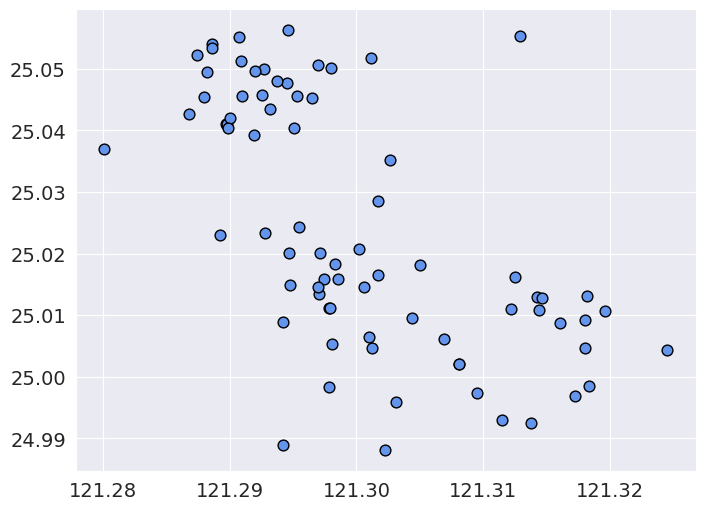

In [20]:
ax = start_plot(figsize=(8, 6), style='darkgrid')

ax.scatter(cafe[:, 0], cafe[:, 1], s=60, edgecolor = 'k',
    c='cornflowerblue')

# K-Means

- [sklearn KMeans API](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans)
- [Understanding K-Means, K-Means++ and, K-Medoids Clustering Algorithms](https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca)

In [21]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(cafe)

KMeans(n_clusters=4)

In [22]:
labels = model.fit_predict(cafe)
centroids = model.cluster_centers_
centroids

array([[121.31655282,  25.01041564],
       [121.29279513,  25.04679987],
       [121.29796027,  25.01614418],
       [121.30707408,  24.99729723]])

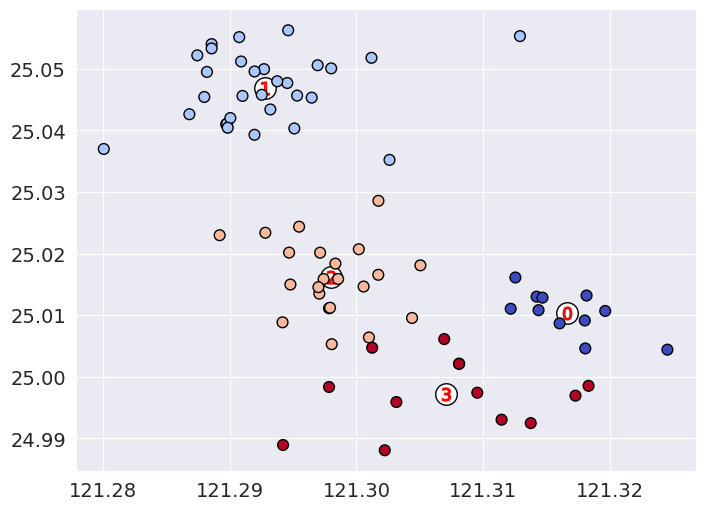

In [23]:
ax = start_plot(figsize=(8, 6), style='darkgrid')

ax.scatter(cafe[:, 0], cafe[:, 1], s=60,
     edgecolor = 'k', cmap = 'coolwarm', c=labels, zorder=2)
ax.scatter(centroids[:,0], centroids[:,1], s=240, marker = 'o',
     c = 'white',edgecolor = 'k')
for i, c in enumerate(centroids):
    ax.scatter(c[0], c[1], s=85, marker='$%d$' % i,
        edgecolor='red')

In [24]:
model.labels_, model.cluster_centers_

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 0, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 0, 3, 2, 1, 1, 3, 3, 1,
        3, 3, 2, 2, 3, 3, 3, 2, 2, 2], dtype=int32),
 array([[121.31655282,  25.01041564],
        [121.29279513,  25.04679987],
        [121.29796027,  25.01614418],
        [121.30707408,  24.99729723]]))

In [48]:
df = pd.read_csv(os.path.join(data_dir, 'Mall.csv'))
X = df.iloc[:,[3,4]].values

n_k = 6
seed = 1

models = [
    KMeans(n_clusters=n_k, init='random', n_init=1,
           max_iter=i+1, random_state=seed,algorithm='lloyd')
    for i in range(3)
]

lbls = [model.fit_predict(X) for model in models]

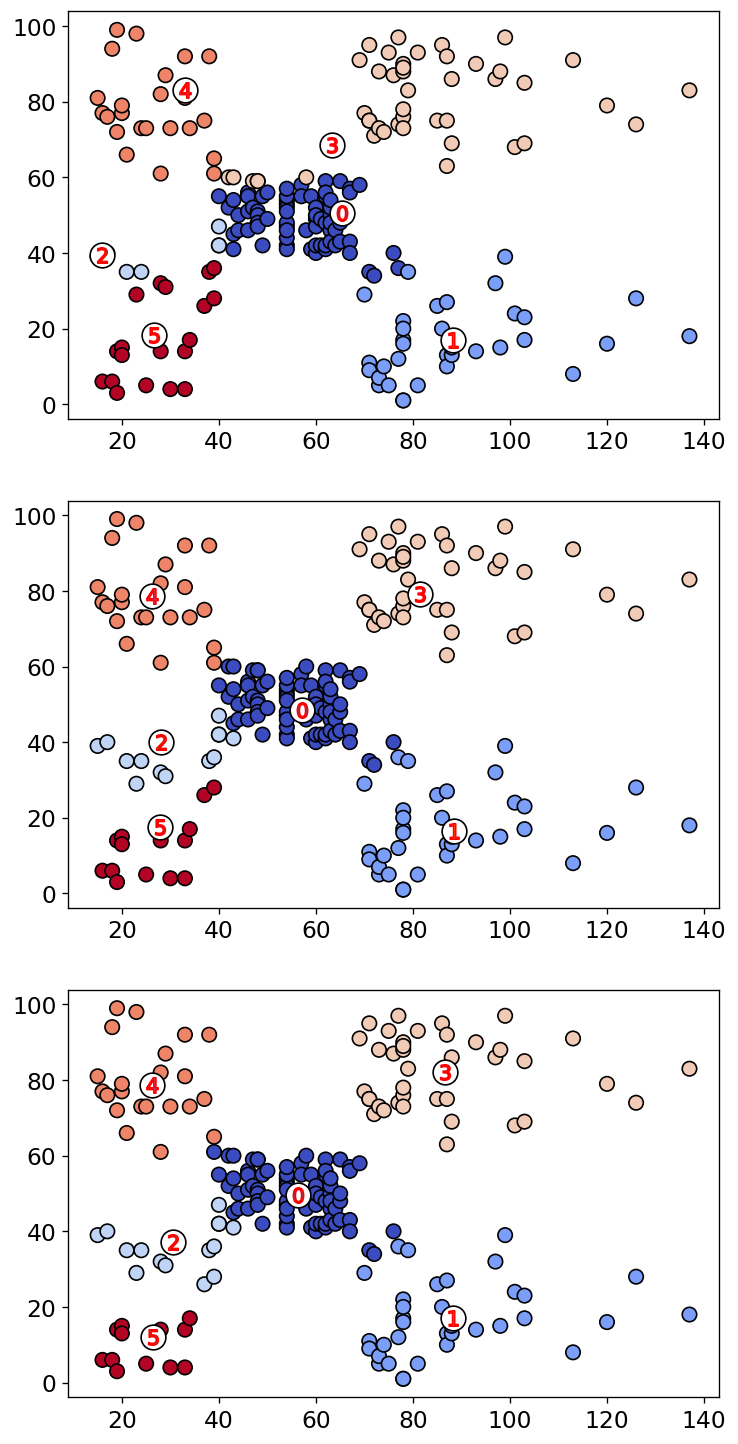

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(7, 15), dpi=120)

for i in range(3):
    ax[i].scatter(X[:,0], X[:,1],
        s=75, c=lbls[i], edgecolor='k',
        cmap='coolwarm')
    centroids = models[i].cluster_centers_
    ax[i].scatter(centroids[:,0],centroids[:,1], s = 220,
        marker='o', c='w', edgecolor='k')
    for j, c in enumerate(centroids):
        ax[i].scatter(c[0], c[1], marker='$%d$' % j,
            s=85, edgecolor='r')

### Decision Bundary of KMeans

- [countour](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html)
- [countourf](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html#matplotlib.pyplot.contourf)
- [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html)
 - [例圖](https://i.stack.imgur.com/LsjwA.png)

In [50]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def cafe_boundries(model, data, resolution = 1000,
    plot_centroids = False,
    figsize=(12,10), style='whitegrid'):

    mins = data.min(axis=0) - 0.01
    maxs = data.max(axis=0) + 0.01
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = start_plot(figsize=figsize, style = style)

    ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
               cmap="Pastel1", alpha = 0.2)
    ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k', alpha = 0.6)

    # labels = model.predict(data)
    labels = model.labels_
    ax.scatter(data[:,0], data[:,1], c = labels,
        cmap = 'coolwarm', edgecolor='navy', s=75)

    centroids = model.cluster_centers_
    ax.scatter(centroids[:,0], centroids[:,1], marker = 'o',
        s = 220, edgecolor = 'k', c = 'w')
    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker = '$%d$' % i,
            s = 80, edgecolor = 'r')


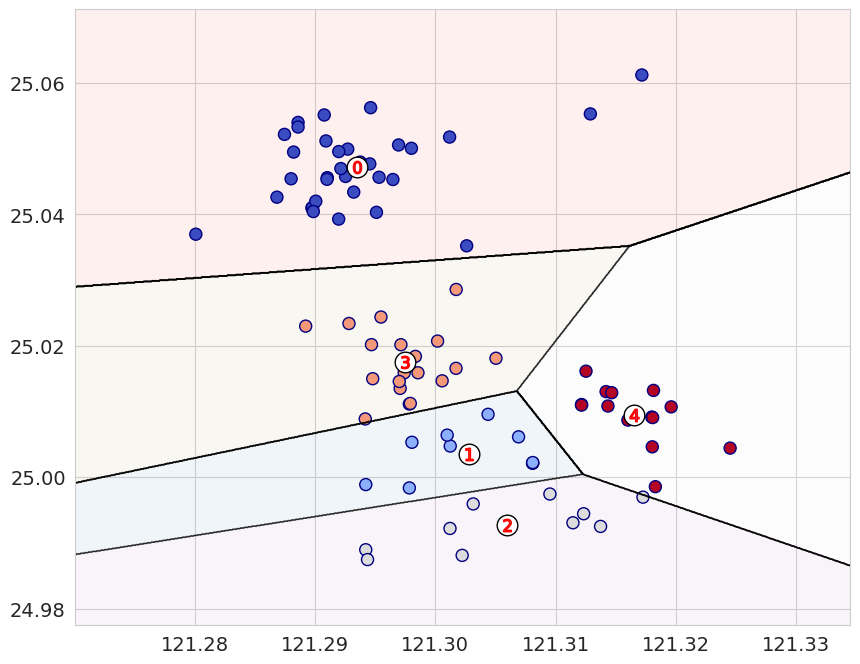

In [51]:
n_k = 5
df = pd.read_csv(os.path.join(data_dir, 'coffee7.csv'))
X = df[coord].values
model = KMeans(n_clusters = n_k).fit(X)
cafe_boundries(model, X, style = 'whitegrid', figsize=(10, 8),
    plot_centroids = True)


# Elbow Method


- inertia_:

    float, Sum of squared distances of samples to their closest cluster center.

In [52]:
df = pd.read_csv(os.path.join(data_dir, 'coffee6.csv'))
cafe = df[coord].values
model = KMeans(n_clusters=4)
model.fit(cafe)

KMeans(n_clusters=4)

In [53]:
model.score(cafe)

-0.004246924171982107

In [54]:
model.inertia_

0.004246924171982109

In [55]:
kmodels = [KMeans(n_clusters=k).fit(cafe)
    for k in range(2, 10)]
scores = [model.inertia_ for model in kmodels]

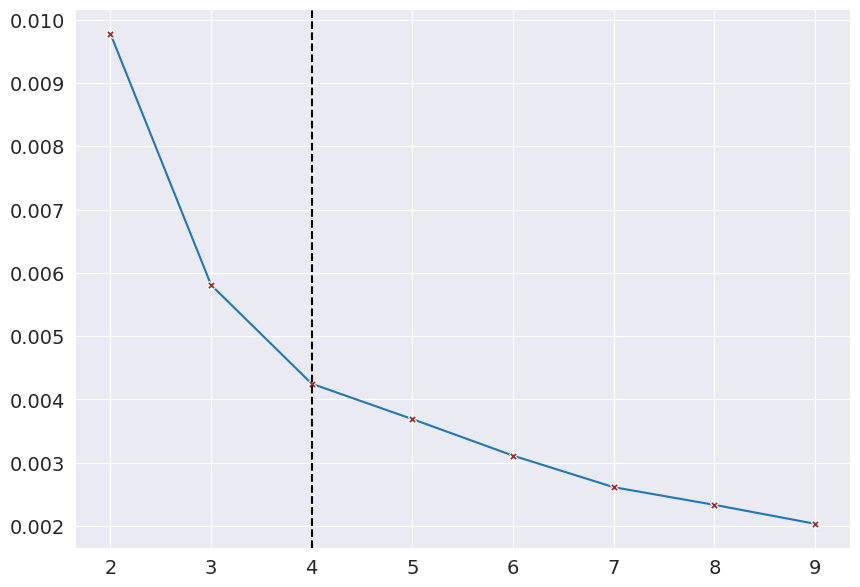

In [58]:
ax = start_plot(figsize=(10,7), style='darkgrid')
sns.lineplot(x=range(2,10), y=scores, ax=ax,
    mfc='brown',marker='X')
ax.axvline(x=4, ls='--', c='k')
output_fig('elbow - coffee map')

In [43]:
list(range(2,10))

[2, 3, 4, 5, 6, 7, 8, 9]

# Silhouette scores

$s(x_i) = \frac{ b(x_i) - a(x_i)}{ \max \{ a(x_i), b(x_i) \}} , \ it\ is\ clear\ that\ -1 \le s(x_i) \le 1$

輪廓係數法的概念是「找出同群資料點內最近/不同群越分散」的值，也就是滿足 Cluster 的定義，b為不同群之間的點平均距離，a為同群之間的距離。S越大越好，代表分得越清楚。

- [sklearn silhouette_samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples)
- [sklearn silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)
- [silhouette analysis source code](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
- [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

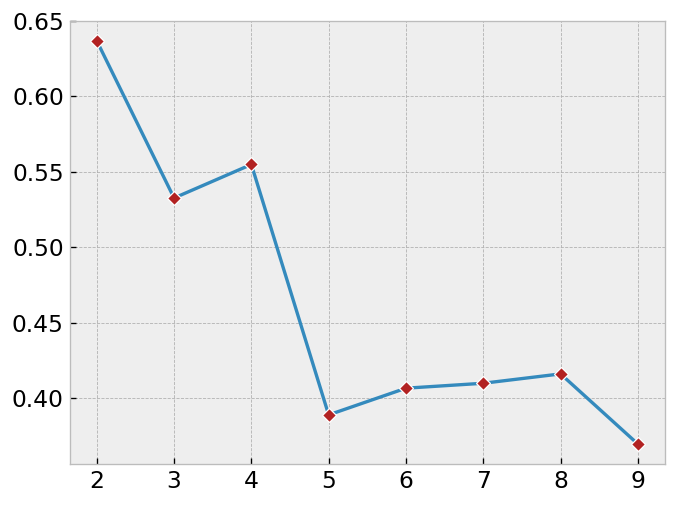

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score

df = pd.read_csv(os.path.join(data_dir, 'coffee6.csv'))
cafe = df[coord].values

range_k = range(2, 10)

savg = []

for n in range(2,10):
    model = KMeans(n_clusters=n)
    labels = model.fit_predict(cafe)
    sil_avg = silhouette_score(cafe, labels)
    savg.append(sil_avg)

with plt.style.context('bmh'):
    _, ax = plt.subplots(dpi=120)
    sns.lineplot(x=range_k,y=savg, marker='D', mfc='firebrick')


# DBSCAN
- [DBSCAN demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py)

In [61]:
from sklearn.cluster import DBSCAN

df = pd.read_csv(os.path.join(data_dir, 'coffee6.csv'))
cafe = df[coord].values

model = DBSCAN(eps=0.005, min_samples=4)
labels = model.fit_predict(cafe)

In [62]:
n_clusters_ = len(set(labels)) - \
    (1 if -1 in set(labels) else 0)
n_noise_ = list(labels).count(-1)

print('%d estimated clusters' % n_clusters_)
print('%d noise points' % n_noise_)

5 estimated clusters
12 noise points


In [63]:
labels = np.array([x+1 for x in model.labels_])

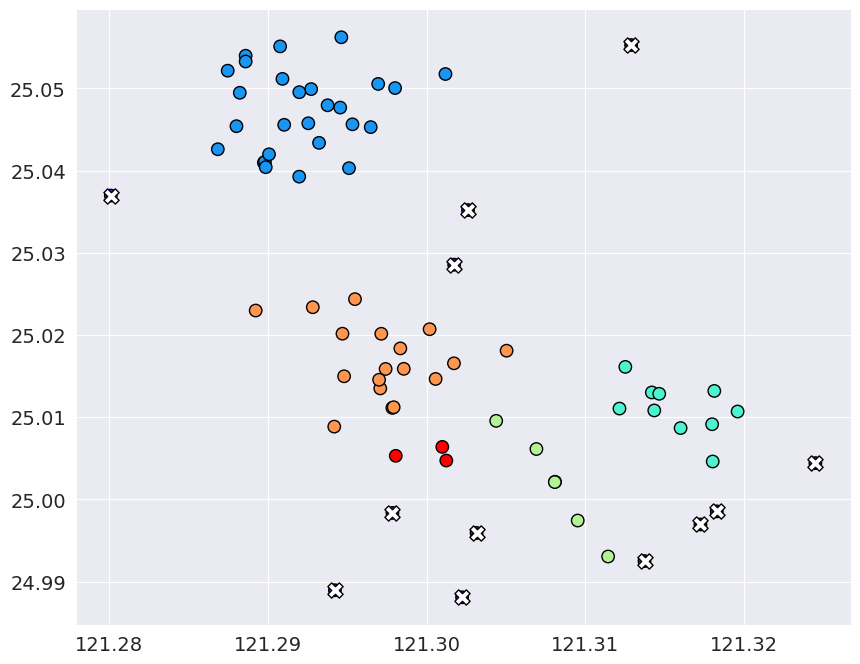

In [64]:

ax = start_plot(style='darkgrid')
ax.scatter(cafe[:,0], cafe[:,1], s=80, edgecolor='k',
    c=labels, cmap='rainbow')

for c, p in zip(labels, cafe):
    if (c!=0):
        continue
    ax.scatter(p[0], p[1], color='w', marker='X',
        s=120, edgecolor='k')

### plot_dbscan

In [65]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def cafe_boundries(model, data, resolution = 1000,
    plot_centroids = False,
    figsize=(12,10), style='whitegrid'):

    mins = data.min(axis=0) - 0.01
    maxs = data.max(axis=0) + 0.01
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax = start_plot(figsize=figsize, style = style)

    ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
               cmap="Pastel1", alpha = 0.2)
    ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k', alpha = 0.6)

    # labels = model.predict(data)
    labels = model.labels_
    ax.scatter(data[:,0], data[:,1], c = labels,
        cmap = 'coolwarm', edgecolor='navy', s=75)

    centroids = model.cluster_centers_
    ax.scatter(centroids[:,0], centroids[:,1], marker = 'o',
        s = 220, edgecolor = 'k', c = 'w')
    for i, c in enumerate(centroids):
        ax.scatter(c[0], c[1], marker = '$%d$' % i,
            s = 80, edgecolor = 'r')


In [66]:
from sklearn.cluster import DBSCAN

def plot_dbscan(data, max_distance = 0.005,
    min_samples = 5,
    ax=None):
    if ax is None:
        ax = start_plot(figsize = (10, 8), style = 'darkgrid')

    max_distance = max_distance
    min_samples = min_samples

    db = DBSCAN(eps=max_distance, min_samples=min_samples).fit(data)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # plt.tight_layout()
    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    X = data

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='navy', markersize=14)
        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=7,
                label = 'k = %d' % k if k != -1 else 'noise point')
    ax.set_title('DBSCAN on Coffe Map: estimated cluster = %d' % n_clusters_)
    ax.legend(title = 'eps=%.3f min_samples=%d' % (max_distance, min_samples),
            title_fontsize = 13, fontsize = 13,
            loc = 'best', shadow = True)

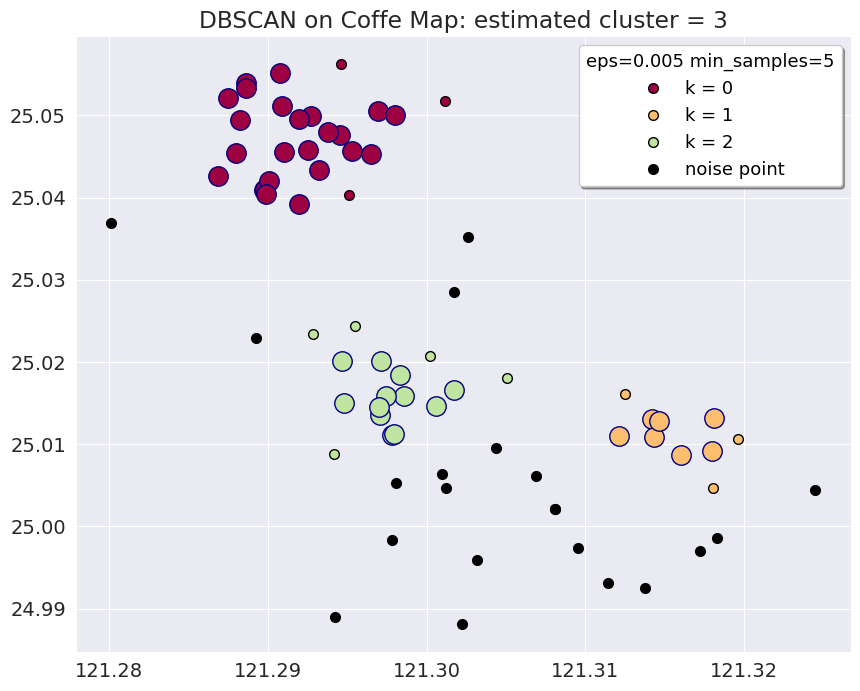

In [67]:
plot_dbscan(cafe)

# Kernelized KMeans - SpectralClustering

- [cluster.SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html?highlight=spectralclustering#sklearn.cluster.SpectralClustering)

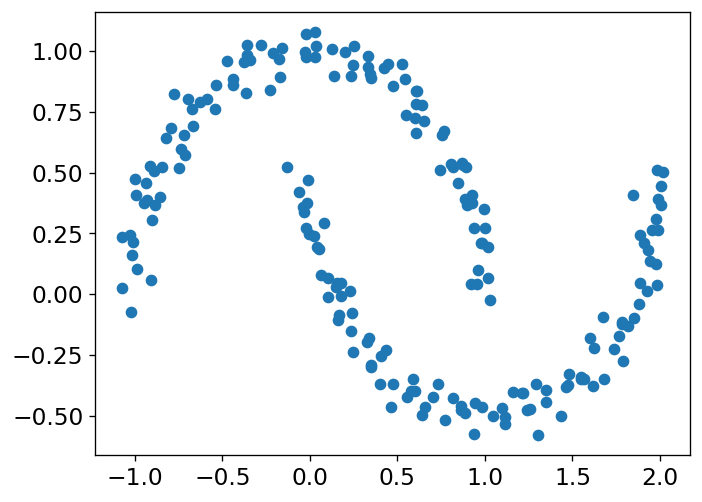

In [68]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(200, noise=0.05, random_state=0)

fig = plt.figure(dpi=120)
plt.scatter(Xm[:,0], Xm[:,1])

In [69]:
rs = np.random.seed(25)

def generate_circle_sample_data(r, n, sigma):
    """Generate circle data with random Gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    return x, y

def concentric_circles_data(alpha):
    X1, y1 = generate_circle_sample_data(2, 1000, alpha)
    X2, y2 = generate_circle_sample_data(4, 1000, alpha)
    X3, y3 = generate_circle_sample_data(6, 1000, alpha)
    X = np.append(np.append(X1, X2), X3)
    y = np.append(np.append(y1, y2), y3)
    df = pd.DataFrame({'X':X, 'y': y})
    return df.values

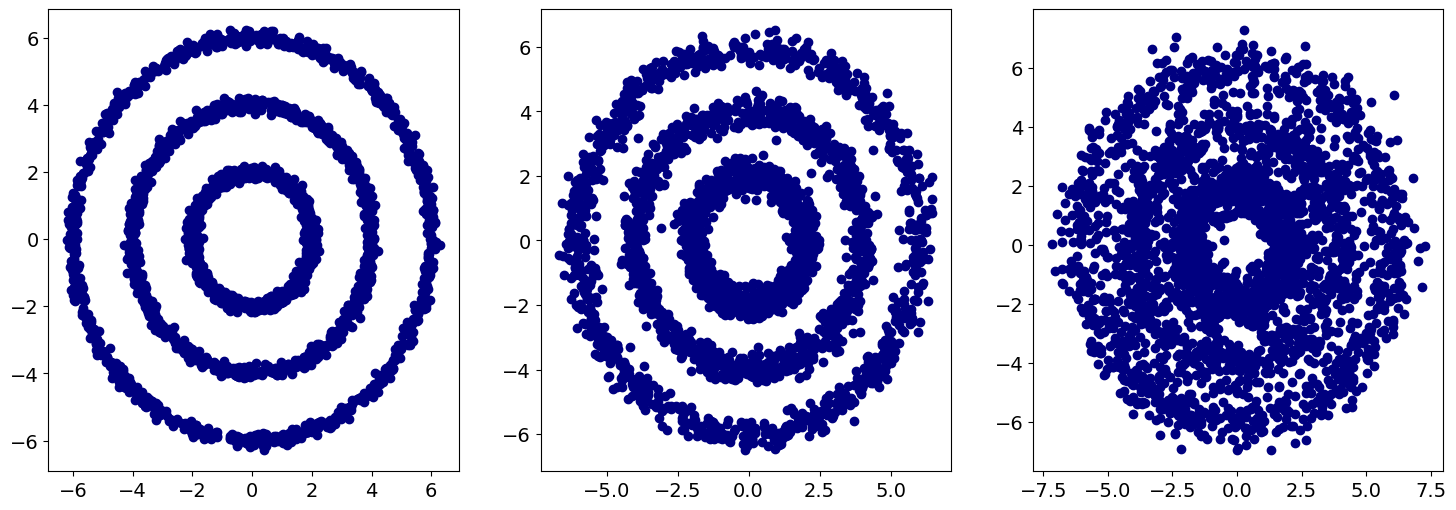

In [70]:
alphas = [0.1, 0.25, 0.5]

fig,ax = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

for i in range(3):
    data = concentric_circles_data(alphas[i])
    ax[i].scatter(data[:,0], data[:,1], c='navy')

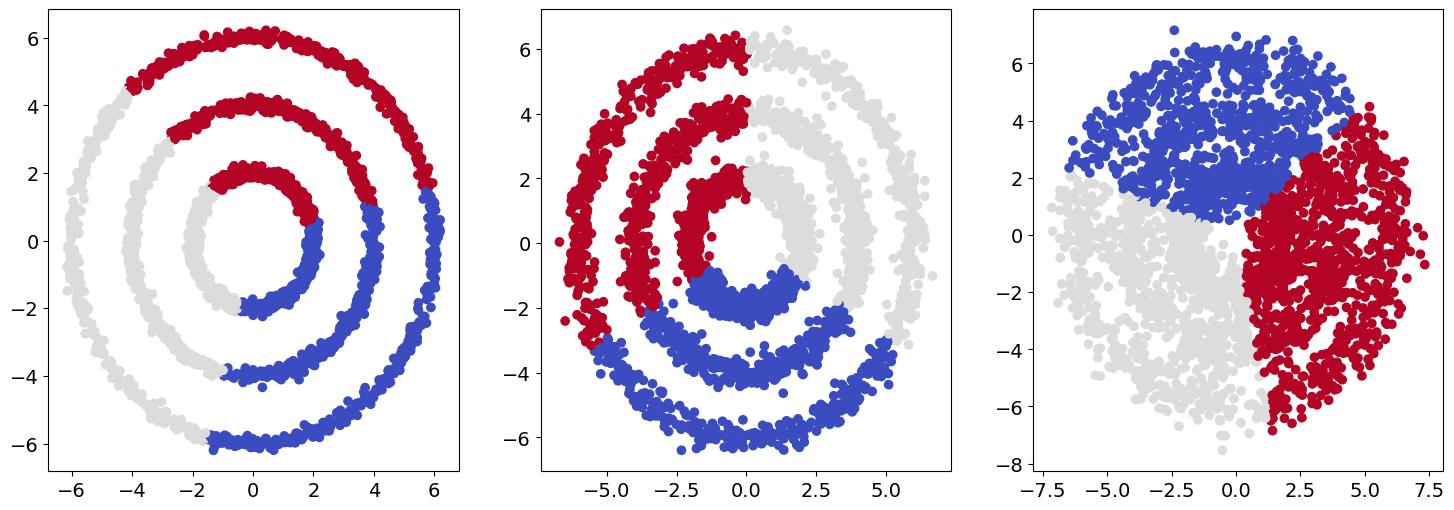

In [71]:
alphas = [0.1, 0.25, 0.5]

fig,ax = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

for i in range(3):
    data = concentric_circles_data(alphas[i])
    model = KMeans(n_clusters=3)
    labels = model.fit_predict(data)
    ax[i].scatter(data[:,0], data[:,1], c=labels,
        cmap='coolwarm')


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


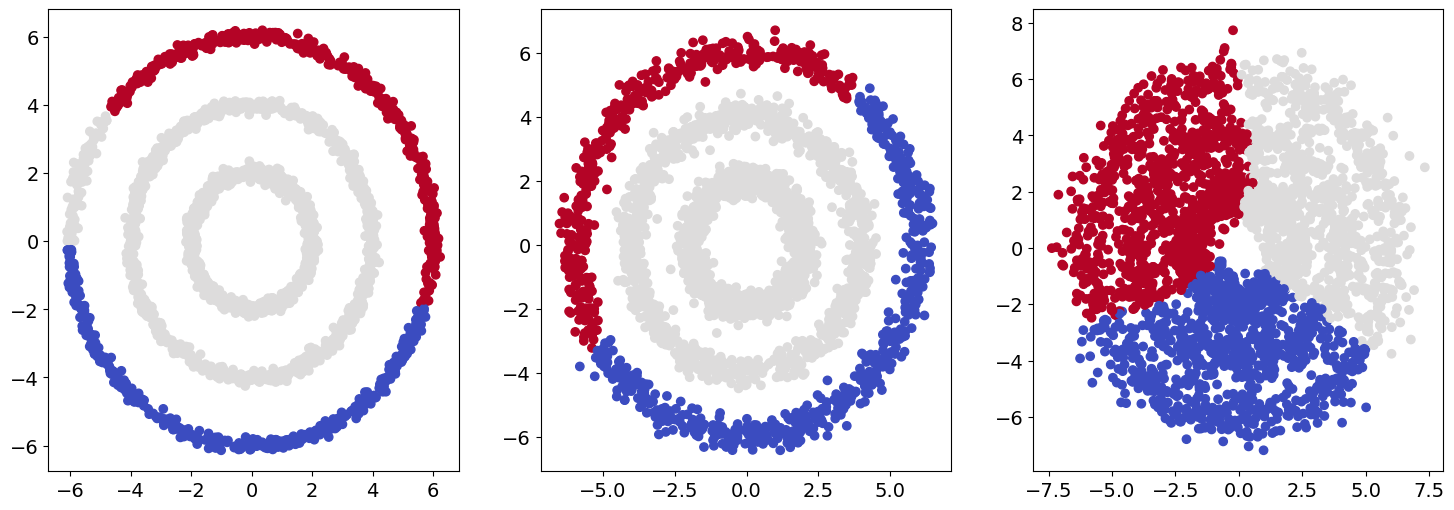

In [72]:
from sklearn.cluster import SpectralClustering

alphas = [0.1, 0.25, 0.5]

fig,ax = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

for i in range(3):
    data = concentric_circles_data(alphas[i])
    model = SpectralClustering(n_clusters =3,
        n_neighbors = 8, random_state = 10,
        affinity = 'nearest_neighbors',
        assign_labels = 'kmeans')
    labels = model.fit_predict(data)
    ax[i].scatter(data[:,0], data[:,1], c=labels,
        cmap = 'coolwarm')


# GMM

使用 Colab 時，可以連接到本地電腦的 Jupyter Notebook，怎麼做

- 第一步：安裝延伸套件：
```
pip3 install --upgrade jupyter_http_over_ws>=0.0.7
jupyter serverextension enable --py jupyter_http_over_ws
```

- 第二步：
重新啟動 Jupyter，記得參數要寫對喔：
```
jupyter notebook \
  --NotebookApp.allow_origin='https://colab.research.google.com' \
  --port=8888 \
  --NotebookApp.port_retries=0
  
```


### get started

In [92]:
df = pd.read_csv(os.path.join(data_dir, 'coffee6.csv'))
coord =['Longitude', 'Latitude']
cafe = df[coord].values
type(cafe)

numpy.ndarray

## preidct_proba

In [97]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4)
gmm.fit(cafe)
labels = gmm.predict(cafe)
probs = gmm.predict_proba(cafe)

In [98]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 0, 0, 2, 2, 0,
       2, 2, 3, 3, 2, 2, 2, 3, 3, 3])

In [99]:
probs.shape

(76, 4)

In [100]:
probs[-5:]

array([[1.79119926e-27, 1.29901023e-33, 9.96390919e-01, 3.60908058e-03],
       [4.27960916e-24, 9.61233087e-47, 9.98915021e-01, 1.08497905e-03],
       [1.85910514e-03, 3.87706101e-13, 5.97584555e-09, 9.98140889e-01],
       [6.03081096e-14, 2.81029315e-10, 4.96849989e-02, 9.50315001e-01],
       [3.44408052e-08, 3.86192004e-11, 2.42975085e-05, 9.99975668e-01]])

In [101]:
np.argsort(probs[0])

array([1, 2, 3, 0])

In [102]:
a = np.array([ x[-1] for x in np.argsort(probs) ])

In [103]:
labels - a

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## file from kaggle

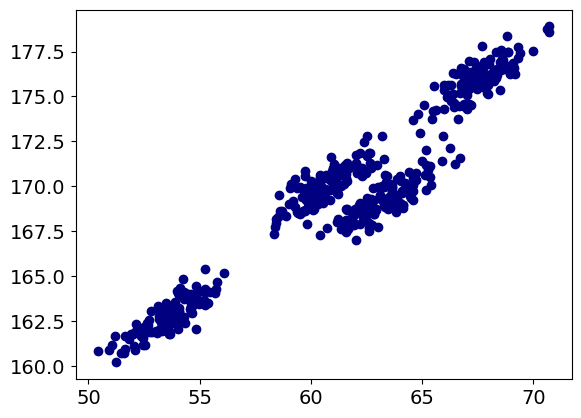

In [104]:
gdf = pd.read_csv(os.path.join(data_dir, 'Clustering_gmm.csv'))
data = gdf.values # np.ndarray
plt.scatter(data[:,0], data[:,1], c='navy')

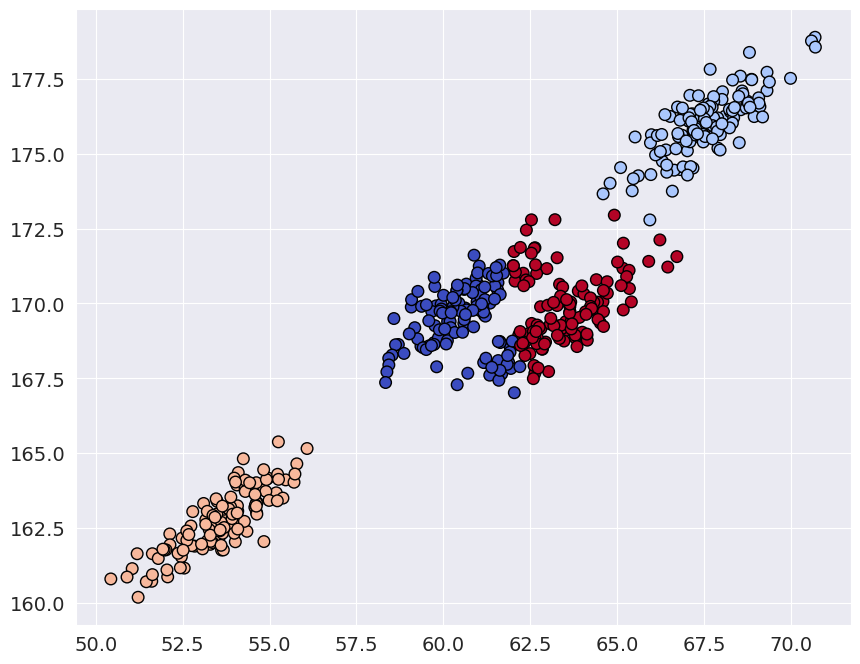

In [105]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4)
labels = model.fit_predict(data)
ax = start_plot(style='darkgrid')
ax.scatter(data[:,0], data[:,1], s=70, c=labels,
        edgecolor = 'k', cmap = 'coolwarm')


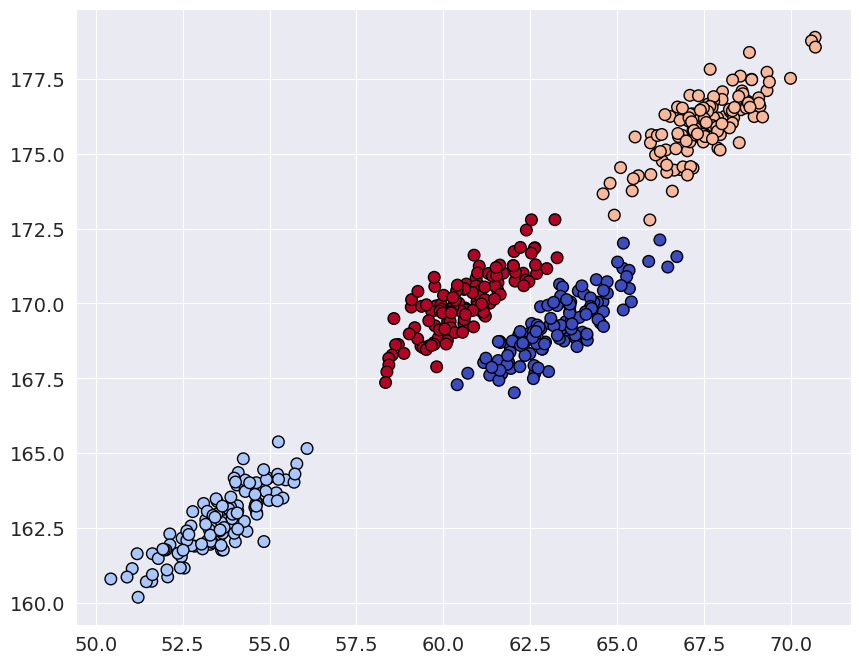

In [106]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.fit(data)
labels = gmm.predict(data)
probs = gmm.predict_proba(data)

size = 60 * probs.max(1)**2
ax = start_plot(style='darkgrid')
ax.scatter(data[:,0], data[:,1], s=70, c=labels,
        edgecolor = 'k', cmap = 'coolwarm')

In [107]:
from sklearn.cluster import SpectralClustering

n_k = 4

models = [
    KMeans(n_clusters=n_k),
    GaussianMixture(n_components=n_k, covariance_type='full'),
    SpectralClustering(n_clusters=n_k, n_neighbors=8,
        random_state=42,
        affinity='nearest_neighbors', assign_labels='kmeans')
]

labels = [model.fit_predict(data) for model in models]
titles = ['KMeans', 'GaussianMixture', 'SpectrlClustering' ]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


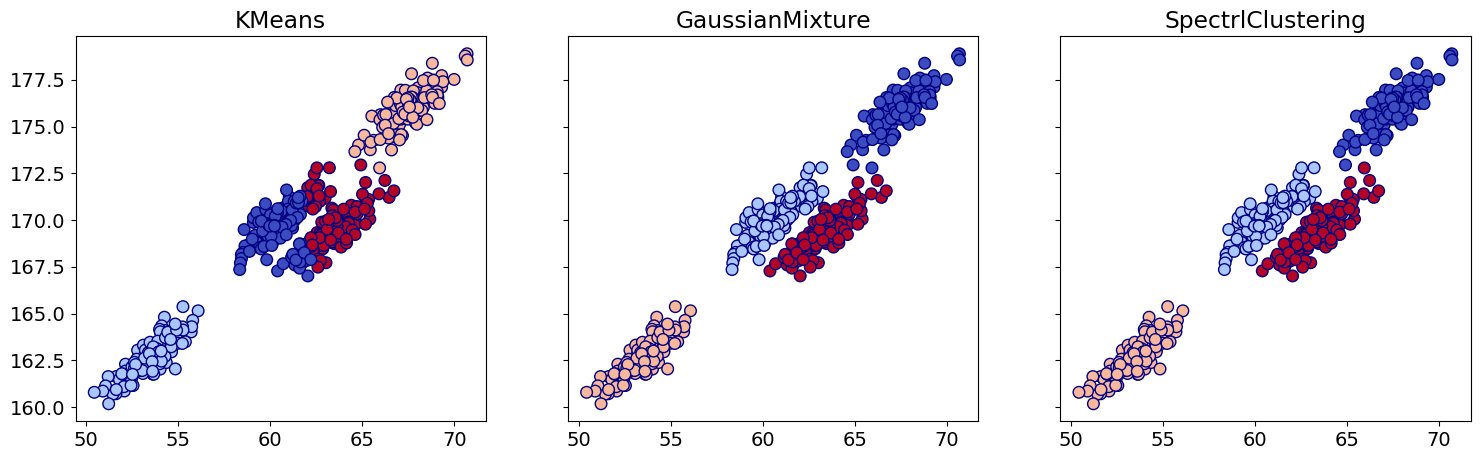

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=True, dpi=100)

for i in range(3):
    ax[i].scatter(data[:,0], data[:,1], s=70, edgecolor='navy',
        c = labels[i], cmap = 'coolwarm')
    ax[i].set_title(titles[i])


## draw ellipse

In [127]:
#
# routines used to draw ellipse and mixture models
#
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
spines_bounds = ['left', 'right', 'bottom', 'top']

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def ty_gmm_map(n_k, train_data, ax=None):
    if ax is None:
        ax = plt.gca()

    train_data = np.array(train_data)
    gmm = GaussianMixture(n_components=n_k).fit(train_data)
    labels = gmm.predict(train_data)
    probs = gmm.predict_proba(train_data)
    size = 60 * probs.max(1) ** 2

    ax.scatter(
        train_data[:, 0], train_data[:, 1],
        c=labels, s=size, cmap='viridis',
        zorder=2, edgecolor=(0, 0, 0)
    )
    ax.set_title(f'TY Map Mixture Model, clusters = {n_k}')

    # 繪製均值點（白色圓圈+編號）
    ax.scatter(
        gmm.means_[:, 0], gmm.means_[:, 1],
        marker='o', c="white", alpha=1,
        s=240, edgecolor='k'
    )
    for i, c in enumerate(gmm.means_):
        ax.scatter(
            c[0], c[1], marker=f'${i}$',
            alpha=1, s=70, edgecolor='r'
        )

    # 繪製橢圓（修正部分）
    w_factor = 0.2 / gmm.weights_.max()
    for position, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2 * np.sqrt(covariance)

        # 修正：使用關鍵字參數傳遞
        for nsig in range(1, 4):
            ellipse = Ellipse(
                xy=position,          # 明確指定中心點
                width=nsig * width,   # 明確指定寬度
                height=nsig * height,  # 明確指定高度
                angle=angle,          # 旋轉角度
                alpha=w * w_factor,   # 透明度
                fill=False,           # 可選：是否填充橢圓
                edgecolor='blue'      # 可選：邊框顏色
            )
            ax.add_patch(ellipse)


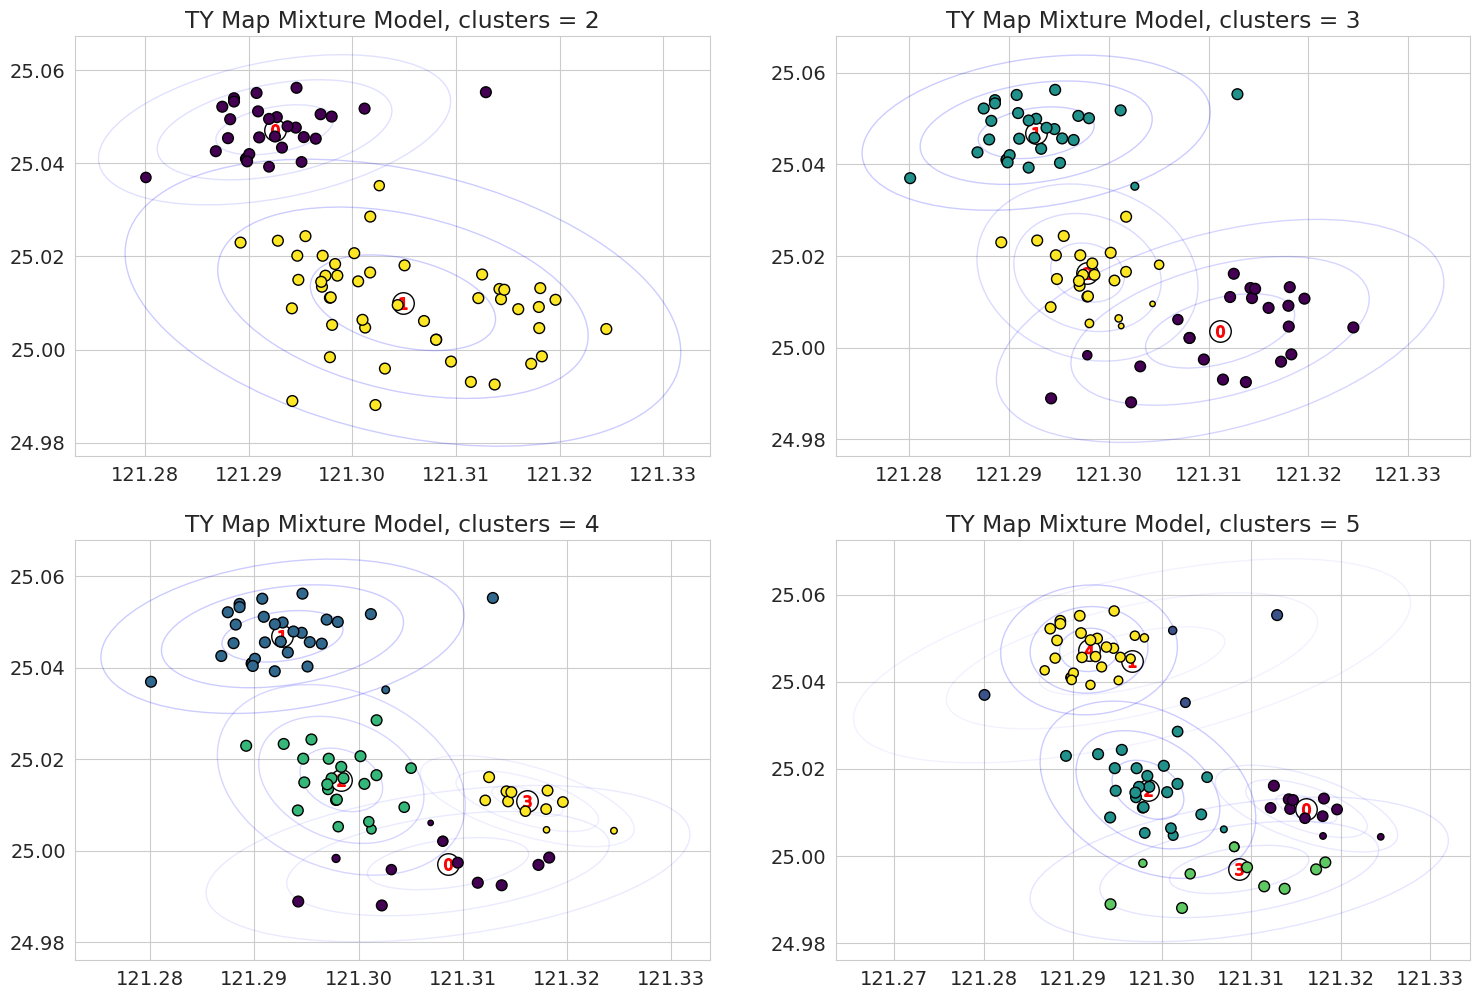

In [129]:
ax = grid_plot(figsize=(18, 12))

for i in range(4):
    ty_gmm_map(i+2, cafe, ax = ax[i])

# KMean vs. GMM

In [88]:


#
# routines used to draw ellipse and mixture models
#
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
import pandas as pd
import numpy as np

spines_bounds = ['left', 'right', 'bottom', 'top']

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def ty_gmm_map(n_k, train_data, ax = plt):

    # bounds = ['left', 'right', 'top', 'bottom']
    train_data = np.array(train_data)

    gmm = GaussianMixture(n_components = n_k).fit(train_data)
    labels = gmm.predict(train_data)
    probs = gmm.predict_proba(train_data)

    size = 60 * probs.max(1) ** 2

    sizelist = [ int(probs[i][labels[i]]*10)* 15+25 for i in range(len(labels))]


    ax.scatter(train_data[:,0],
               train_data[:,1], c=labels, s=size,
               cmap='viridis', zorder=2, edgecolor = (0, 0, 0))

    ax.set_title('TY Map Mixture Model, clusters = %d' % n_k)


    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1], marker='o',
                c="white", alpha=1, s=240, edgecolor='k')

    for i, c in enumerate(gmm.means_):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=70, edgecolor='r')

    w_factor = 0.2 / gmm.weights_.max()
    for position, covariance, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
             angle = 0
             width, height = 2 * np.sqrt(covariance)

        # Draw the Ellipse
        for nsig in range(1, 4):
            # print('width= %7.3f height=%7.3f angle=%d' % (nsig * width , nsig * height , angle))
            ax.add_patch(Ellipse(position, nsig * width , nsig * height,
                                 angle, alpha = w * w_factor))

def plot_dbscan(data, max_distance = 0.005,
    min_samples = 5,
    ax=None):
    if ax is None:
        ax = start_plot(figsize = (10, 8), style = 'darkgrid')

    max_distance = max_distance
    min_samples = min_samples

    db = DBSCAN(eps=max_distance, min_samples=min_samples).fit(data)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # plt.tight_layout()
    # core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    X = data

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='navy', markersize=14)
        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=7,
                label = 'k = %d' % k if k != -1 else 'noise point')
    ax.set_title('DBSCAN on Coffe Map: estimated cluster = %d' % n_clusters_)
    ax.legend(title = 'eps=%.3f min_samples=%d' % (max_distance, min_samples),
            title_fontsize = 13, fontsize = 13,
            loc = 'best', shadow = True)

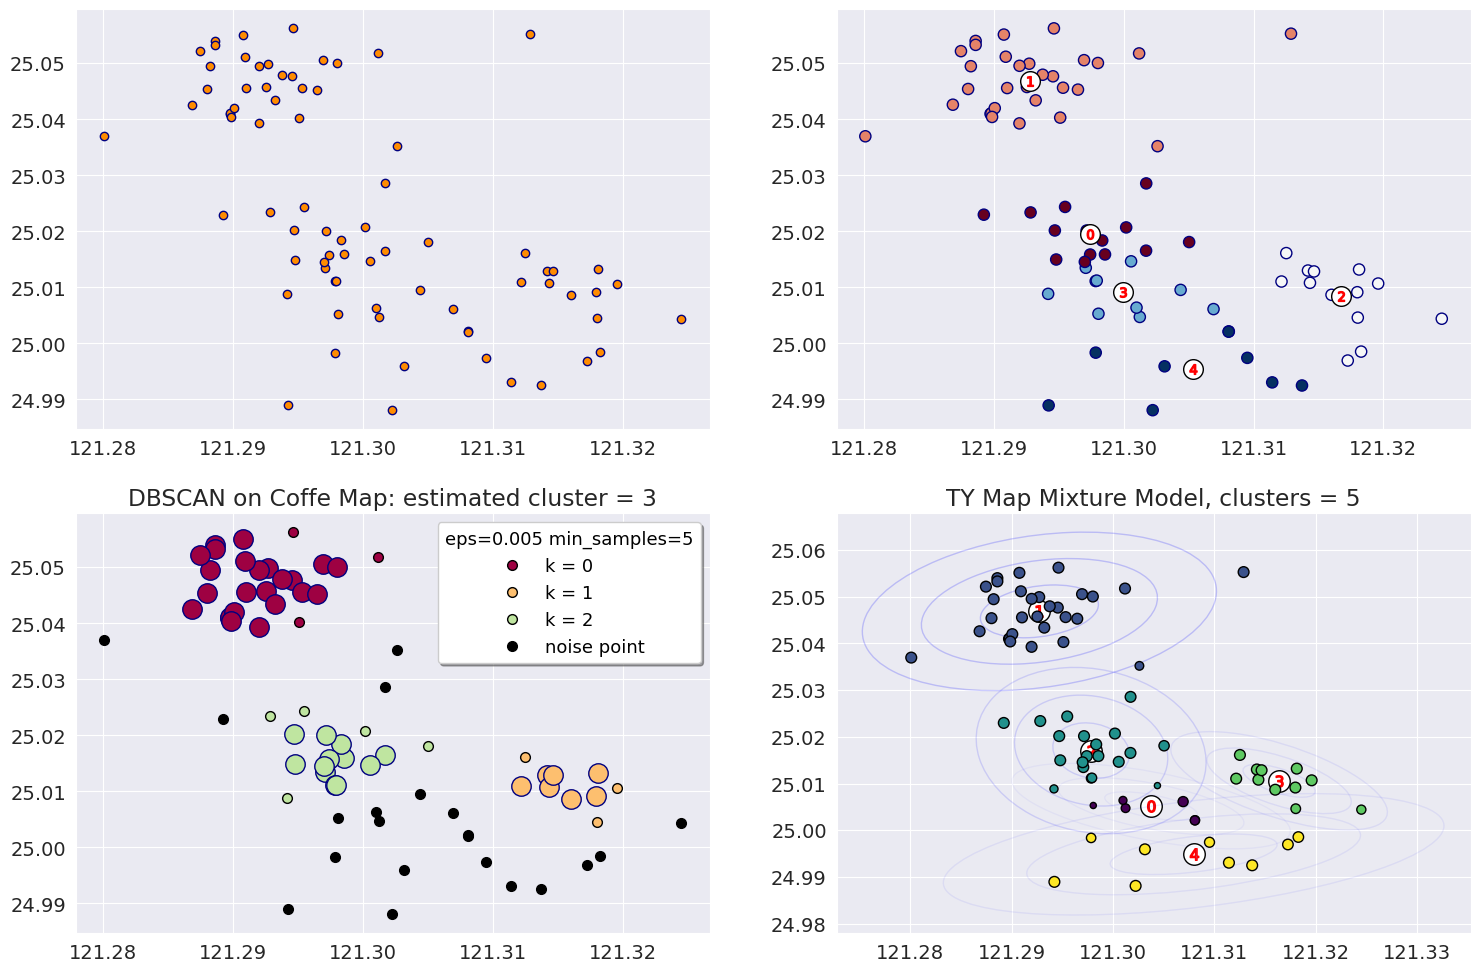

In [130]:
from sklearn.cluster import KMeans, DBSCAN

cafe_pos = df[coord].values
n_clusters = 5

ax = grid_plot(figsize=(18, 12), style='darkgrid')

ax[0].scatter(cafe_pos[:, 0], cafe_pos[:, 1],
    color = 'darkorange', edgecolor = 'navy')

knn = KMeans(n_clusters=n_clusters)
which_clusters = knn.fit_predict(cafe_pos)
centroids = knn.cluster_centers_
ax[1].scatter(cafe_pos[:,0], cafe_pos[:,1], s = 65,
    c = which_clusters, edgecolor = 'navy', cmap = 'RdBu')

ax[1].scatter(centroids[:, 0], centroids[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centroids):
    ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='r')

plot_dbscan(cafe_pos, ax = ax[2])
ty_gmm_map(n_clusters, cafe_pos, ax = ax[3])

output_fig(f'coffee - {n_clusters:d}')

# You Ain't See Anything Yet


